In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: NVIDIA GeForce GTX 1650


device(type='cuda')

In [2]:
# %%time

import h5py
# import zipfile
# import imageio
# import os
# import cv2

# hdf5_file = 'montage/montage_small.h5py'

# total_images = 8071

# with h5py.File(hdf5_file, 'w') as hf:
#     count = 0
#     with zipfile.ZipFile('montage/montage.zip', 'r') as zf:
#         for i in zf.namelist():
#             if (i[-4:] == '.png'):
#                 ofile = zf.extract(i)
#                 img = imageio.imread(ofile)
#                 img = cv2.resize(img, dsize = (180, 240), interpolation=cv2.INTER_CUBIC)
#                 os.remove(ofile)
#                 hf.create_dataset('montage/'+str(count)+'.png', data=img, compression="gzip", compression_opts=9)
#                 count = count + 1
#                 if (count%1000 == 0):
#                     print("images done .. ", count)
#                     pass
#                 if (count == total_images):
#                     break
#                 pass
#             pass
#         pass

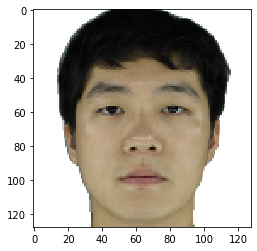

In [3]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

def crop_center(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width // 2 - new_width // 2
    starty = height // 2 - new_height // 2
    return img[starty:starty + new_height, startx:startx + new_width, :]

class MontageDataset(Dataset):
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['montage']
        pass

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        img = np.array(self.dataset[str(index)+'.png'])
        img = crop_center(img, 128, 128)
        return torch.cuda.FloatTensor(img).permute(2, 0, 1).view(1, 3, 128, 128) / 255.0

    def plot_image(self, index):
        img = np.array(self.dataset[str(index)+'.png'])
        img = crop_center(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
        pass
    pass

montage_dataset = MontageDataset('montage/montage_small.h5py')
montage_dataset.plot_image(8070)

In [4]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size = 8, stride = 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
#             nn.GELU(),
            
            nn.Conv2d(256, 256, kernel_size = 8, stride = 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
#             nn.GELU(),
            
            nn.Conv2d(256, 3, kernel_size = 8, stride = 2),
            nn.LeakyReLU(0.2),
#             nn.GELU(),
            
            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )
        self.loss_function = nn.BCELoss()
        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)
        self.optimiser.param_groups[0]['capturable'] = True
        self.counter = 0
        self.progress = []
        pass
    
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns = ['loss'])
        df.plot(ylim = (0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.2, 0.5, 1))
        pass
    pass

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 3*11*11),
            nn.LeakyReLU(0.2),
#             nn.GELU(),
            
            View((1, 3, 11, 11)),
            
            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
#             nn.GELU(),

            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
#             nn.GELU(),

            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),
            
            nn.Sigmoid()
        )
        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)
        self.optimiser.param_groups[0]['capturable'] = True
        self.counter = 0
        self.progress = []
        pass
    
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)
        loss = D.loss_function(d_output, targets)
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns = ['loss'])
        df.plot(ylim = (0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.2, 0.5, 1))
        pass
    pass

In [7]:
%%time

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

epochs = 2

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)
    for image_data_tensor in montage_dataset:
        D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
        D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
        G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))
        pass
    pass

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
epoch =  2
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
CPU times: total: 2h 10min 16s
Wall time: 16min 19s


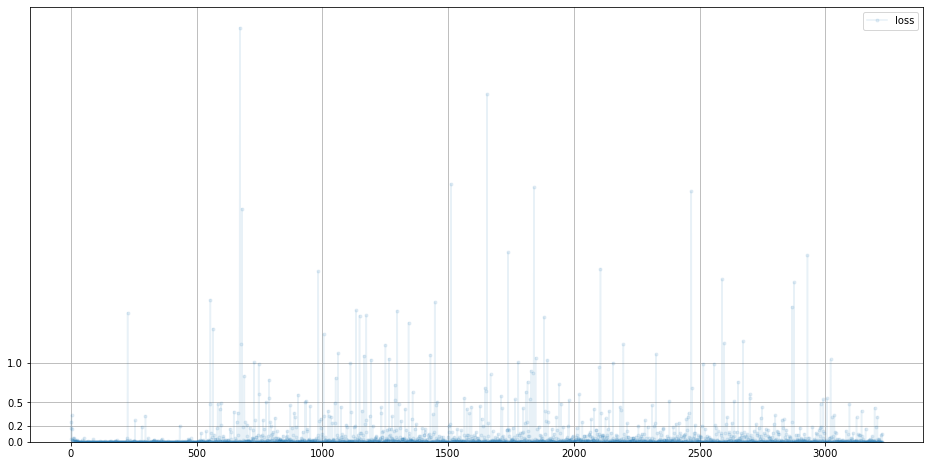

In [8]:
D.plot_progress()

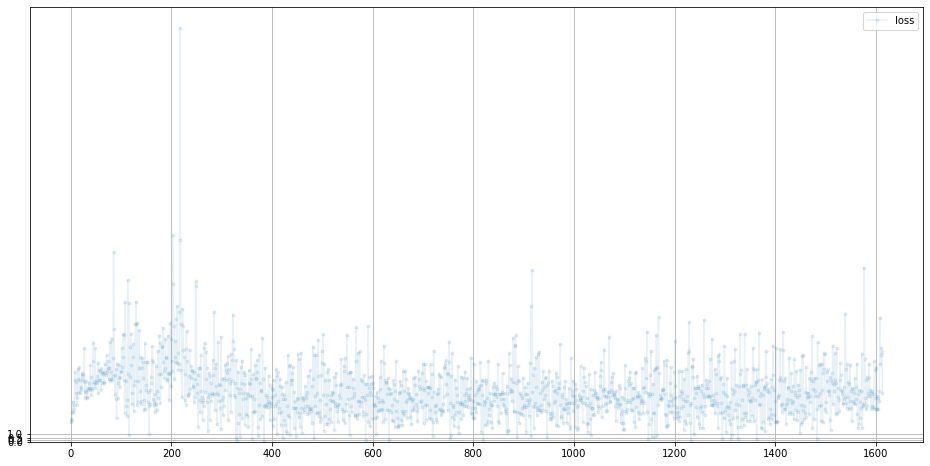

In [9]:
G.plot_progress()

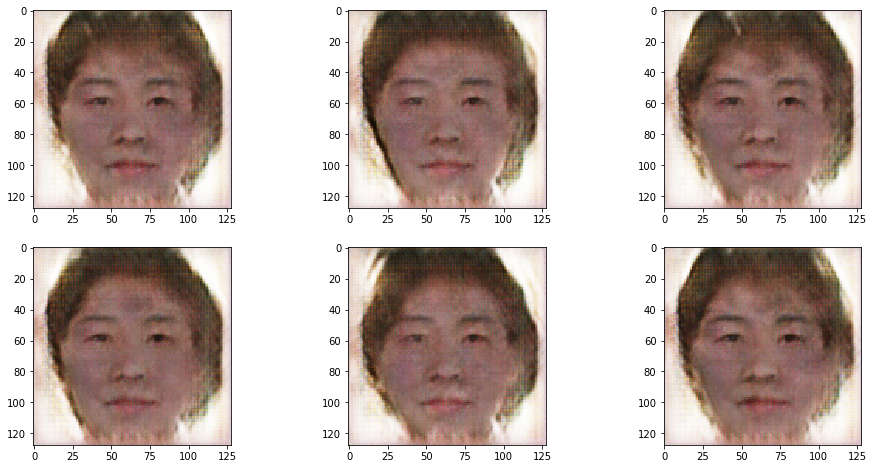

In [10]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size = 8, stride = 2),
            nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),
            nn.GELU(),
            
            nn.Conv2d(256, 256, kernel_size = 8, stride = 2),
            nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),
            nn.GELU(),
            
            nn.Conv2d(256, 3, kernel_size = 8, stride = 2),
#             nn.LeakyReLU(0.2),
            nn.GELU(),
            
            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )
        self.loss_function = nn.BCELoss()
        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)
        self.optimiser.param_groups[0]['capturable'] = True
        self.counter = 0
        self.progress = []
        pass
    
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns = ['loss'])
        df.plot(ylim = (0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.2, 0.5, 1))
        pass
    pass

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 3*11*11),
#             nn.LeakyReLU(0.2),
            nn.GELU(),
            
            View((1, 3, 11, 11)),
            
            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),
            nn.GELU(),

            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),
            nn.GELU(),

            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),
            
            nn.Sigmoid()
        )
        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)
        self.optimiser.param_groups[0]['capturable'] = True
        self.counter = 0
        self.progress = []
        pass
    
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)
        loss = D.loss_function(d_output, targets)
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns = ['loss'])
        df.plot(ylim = (0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.2, 0.5, 1))
        pass
    pass

In [12]:
%%time

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

epochs = 2

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)
    for image_data_tensor in montage_dataset:
        D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
        D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
        G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))
        pass
    pass

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
epoch =  2
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
CPU times: total: 2h 10min 13s
Wall time: 16min 18s


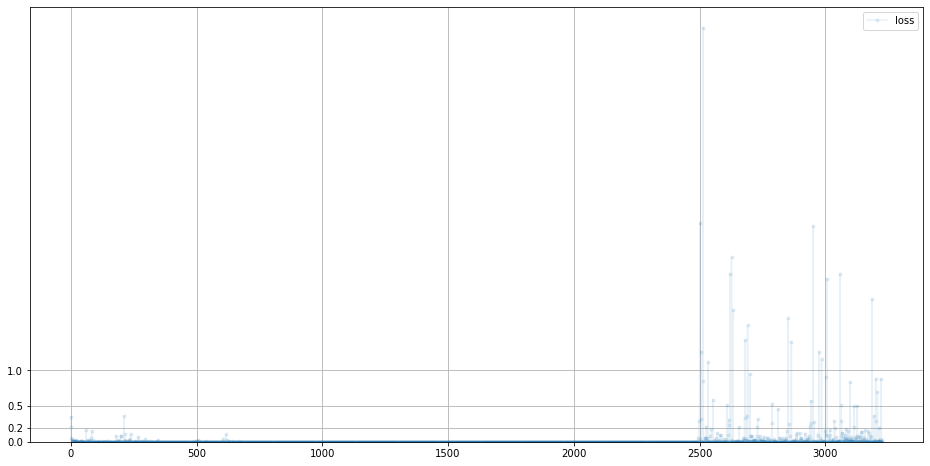

In [13]:
D.plot_progress()

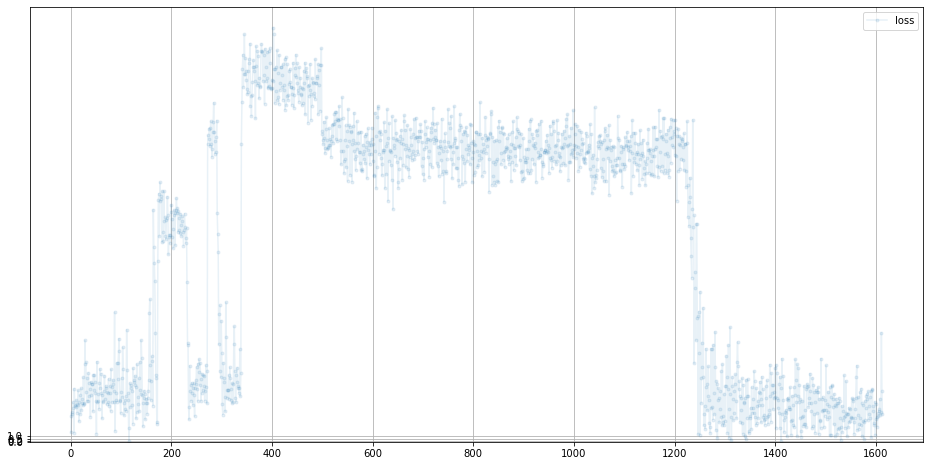

In [14]:
G.plot_progress()

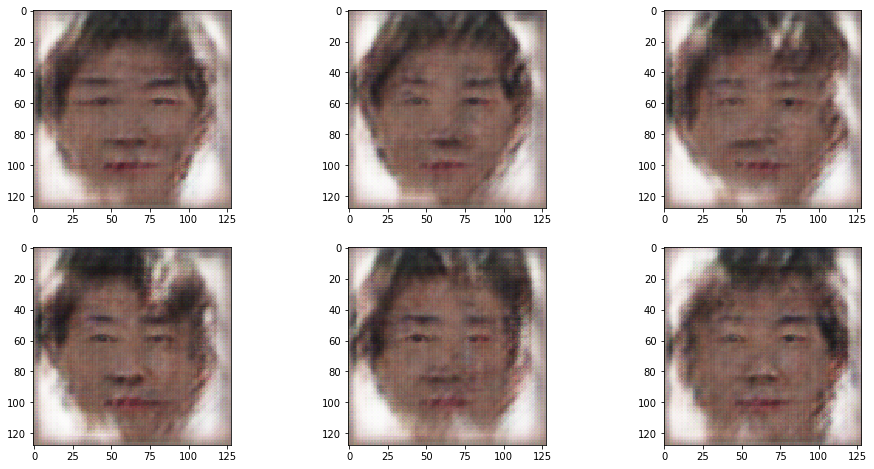

In [15]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass